### ZNE with partial folding to obtain competitive expectation values for deep circuits

Zero Noise Extrapolation (ZNE) is an error mitigation technique used to obtain expectation values closer to the ideal noiseless value from a noisy quantum computer. ZNE can be classified broadly into three types - (i) analog ZNE, (ii) digital ZNE, and (iv) PEA ZNE. In this notebook we select digital ZNE primarily because it has a much simpler implementation than analog ZNE (Physical review letters, 119(18), 180509), and does not require the time consuming $learning$ step of PEA ZNE (Nature, 618(7965), 500-505).

The general idea of digital ZNE (dZNE) is to replace some gates $U$ by $U(U^{\dagger}U)^{\lambda}$ for some $\lambda \geq 1$. This ensures that the functionality of the circuit remains unchanged (since $U^{\dagger}U = I$ $\forall$ $U$), however, the noise is increased due to the increased number of gates. The expectation values are obtained for different values of $\lambda$, and then extrapolated to $\lambda = 0$ to obtain an estimate of the expectation value in zero noise limit.

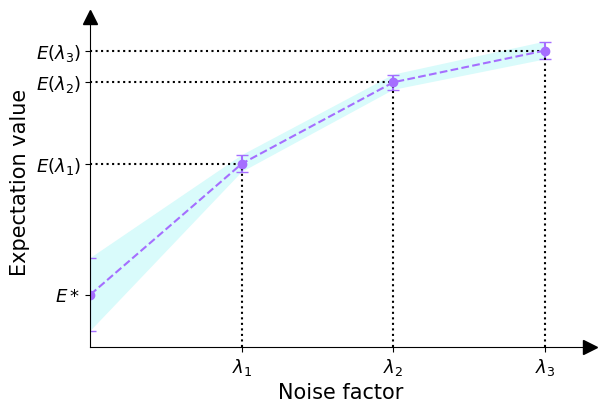

### Start

We shall consider a $p=3$ QAOA circuit as an example for this notebook.

### Build

We consider a compute-uncompute circuit for this notebook. For any circuit, represented by the circuit unitary $U$, a compute-uncompute circuit appends $U^{-1}$ to it. This ensures that, in the noiseless scenario, the outcome is $|0\rangle^{\otimes n}$ where $n$ is the number of qubits. Therefore, the ideal expectation value of any $Z$ type observable is +1. This method ensures that the ideal outcome is known without explicit simulation.

Note that in Qiskit the $U$ and $U^{-1}$ must be separated by a barrier so that the transpiler does not optimize the circuit to identity during execution.

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi

def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    qaoa = QuantumCircuit(num_qubits)
    qaoa.compose(circuit, inplace=True)
    qaoa.barrier()
    qaoa.compose(circuit.inverse(), inplace=True)
    qaoa.measure_active()

    return qaoa

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Here we show an example of a 20 qubits $p=3$ QAOA circuit

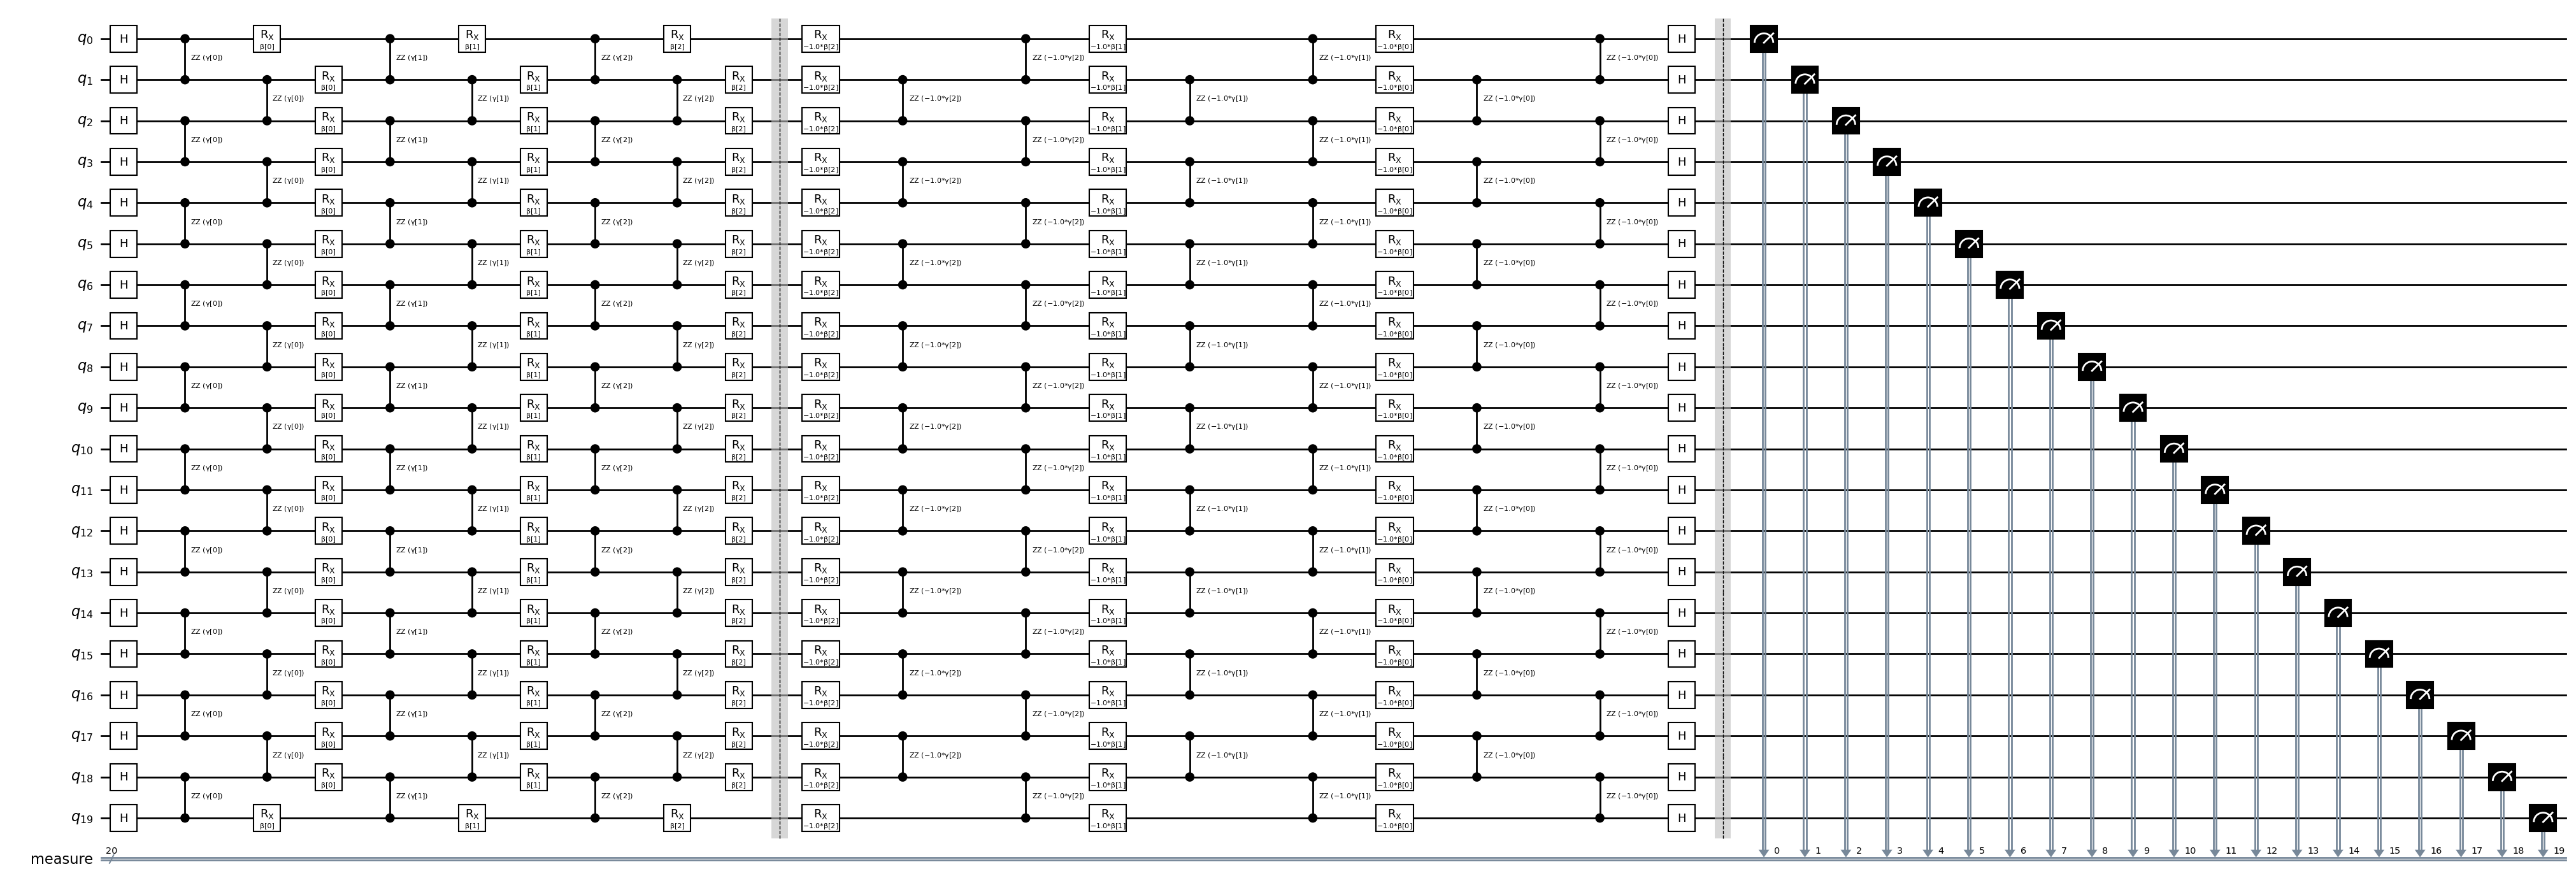

In [3]:
num_qubits = 20
p = 3
qaoa = build_compute_uncompute_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

We assign some random parameters for the qaoa circuit

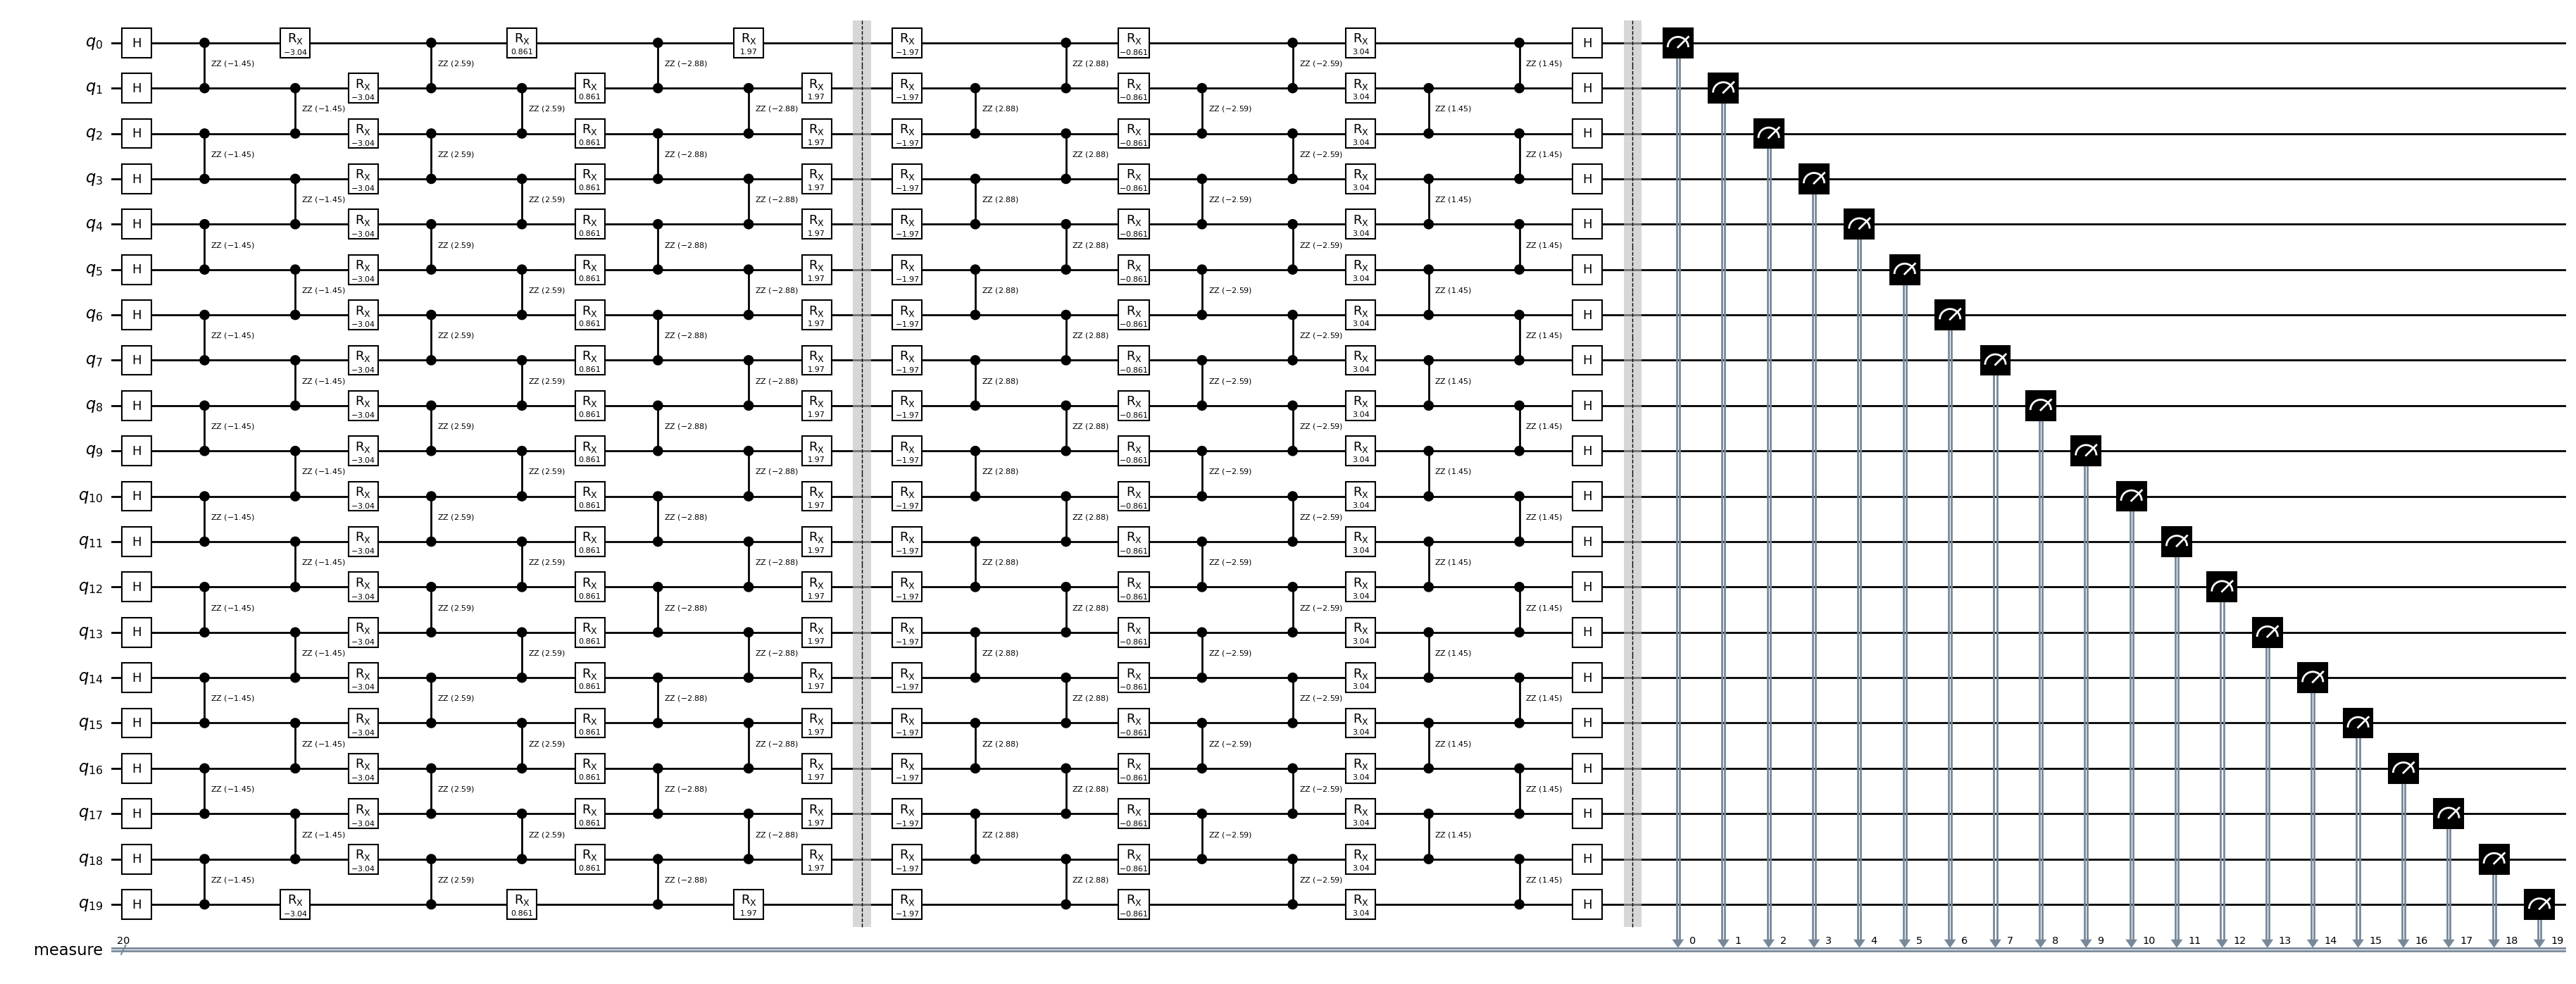

In [4]:
params = produce_qaoa_parameters(p, seed=0)
qaoa = qaoa.assign_parameters(params)
qaoa.draw('mpl', style='bw', fold=-1)

It is useful to transpile the circuit before folding, since that would imply that transpilation is performed only once.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator

In [6]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_auckland')
session = Session(backend=backend)

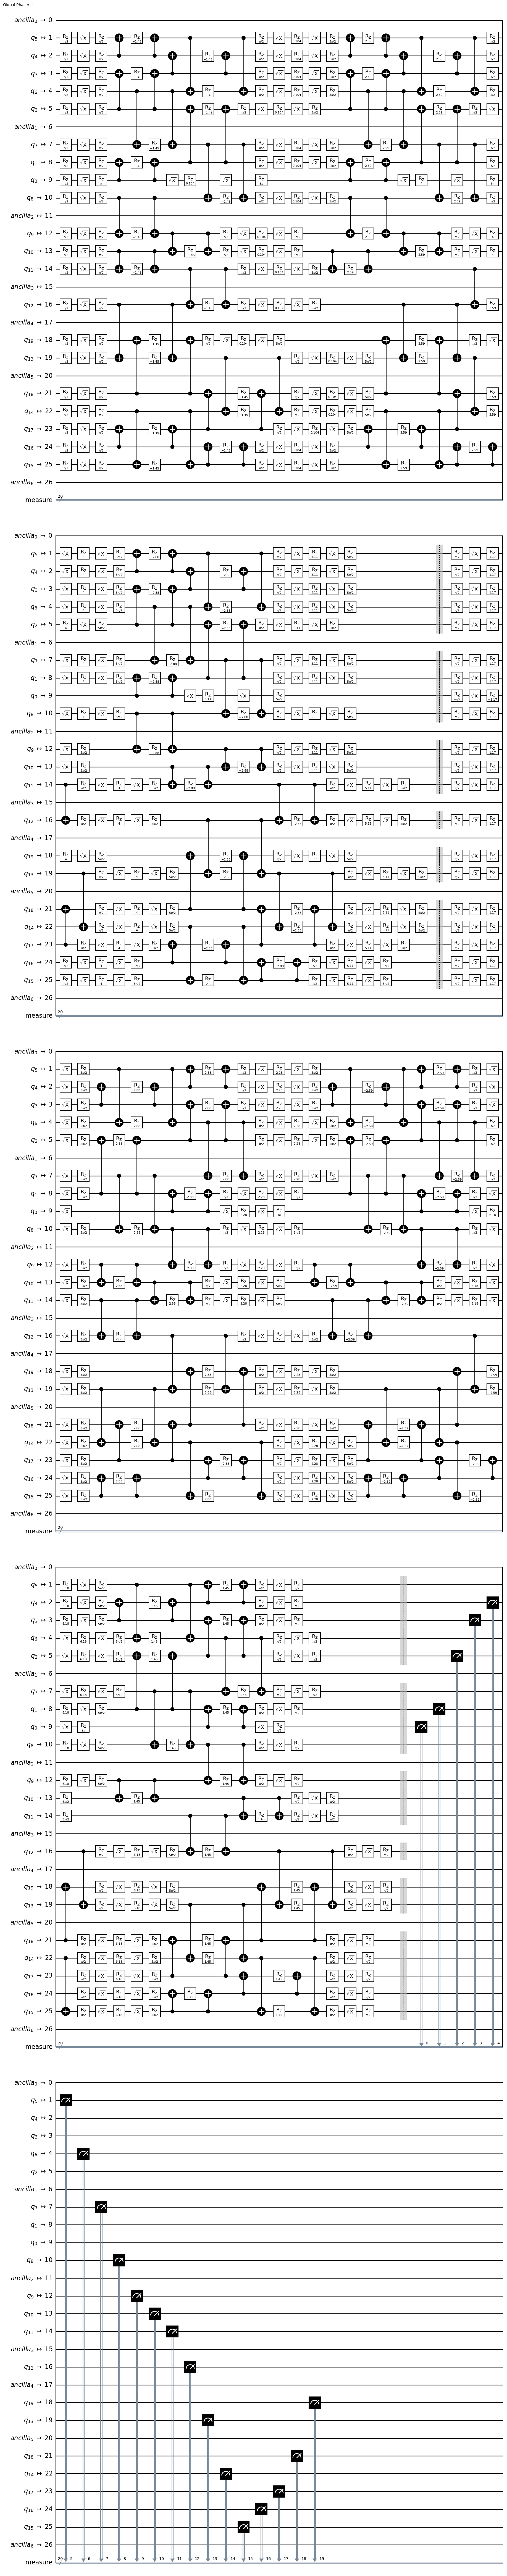

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
trans_qaoa = pm.run(qaoa)
trans_qaoa.draw('mpl', style='bw')

### Optimize

Let us first obtain the 2-qubit depth of the transpiled circuit.

In [8]:
trans_qaoa.depth(lambda x:x[0].num_qubits==2)

24

In general, $\lambda \in \mathbb{Z}$, and the most default values of $\lambda$ used for ZNE are $\{1,3,5\}$. However, we note that the above circuit has a 2-qubit depth of 24. Therefore, folding it with $\lambda = 5$ will create a circuit with 2-qubit depth of 120. The signal obtained from such a deep circuit may not be reliable enough for faithful extrapolation. Therefore, we shift to partial folding, where $\lambda \in \mathbb{R}$. In particular, we shall use $\lambda = \{1,1.2,1.4\}$.

$\lambda = 1.2$ implies that 2 out of 10 gates are selected randomly for folding. Below we show an example of this using the <a href='https://github.com/qiskit-community/prototype-zne/tree/main'>prototype-zne</a> package. Note that for the rest of the notebook, we shall use Qiskit Runtime to incorporate ZNE. This is simply for better visualization.

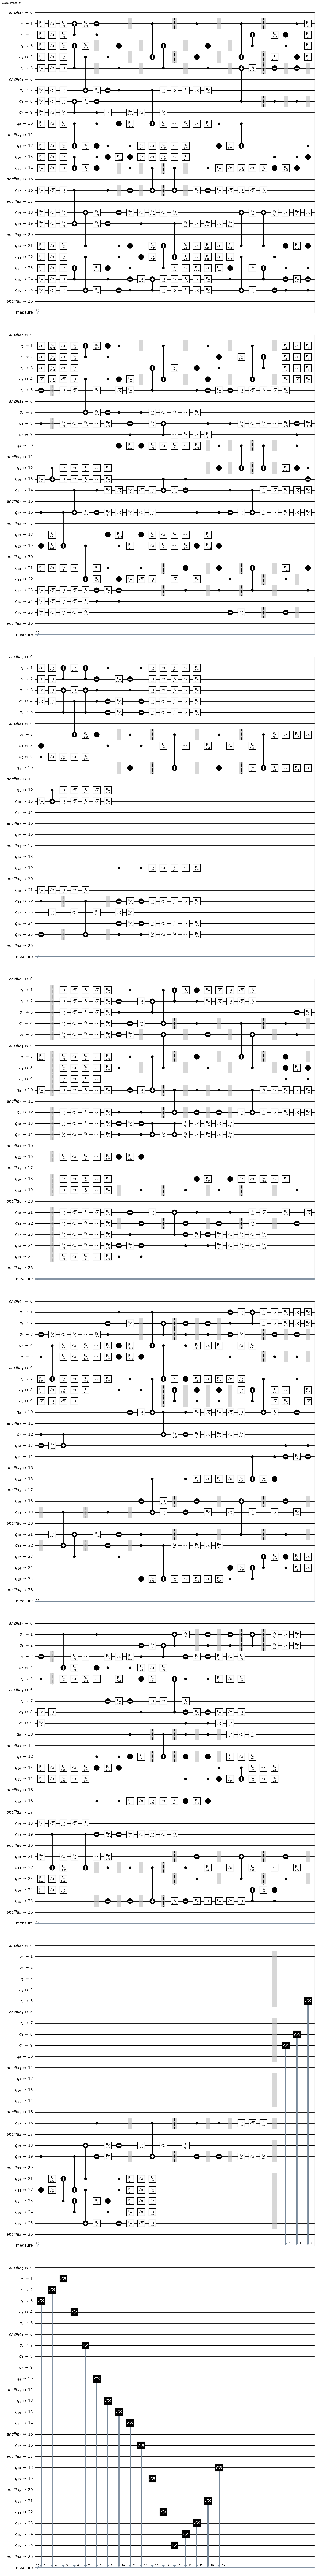

In [9]:
from zne.noise_amplification import TwoQubitAmplifier

noise_amplifier = TwoQubitAmplifier(sub_folding_option='random', random_seed=0)

test_qc = noise_amplifier.amplify_circuit_noise(trans_qaoa, 1.2)
test_qc.draw('mpl', style='bw')

We observe that some of the two qubit gates have been folded. This ensures that 

<ol>
    <li>the depth of the circuit does not increase too much due to folding</li>
    <li>hence, the increase is noise is also low, resulting in better signal</li>
    <li>since the increase in noise is low, low order extrapolator, such as linear, degree-2 polynomial etc. are sufficient for most of the scenarios</li>
</ol>

### Run the circuit

We shall use noise factors ($\lambda$) as $\{1,1.2,1.4\}$. As discussed above, for such a folding, the increase in noise in low, and a linear extrapolator is often sufficient to approximate the zero noise expectation value.

In [11]:
zne_options = Options()
zne_options.resilience_level = 2 # applies ZNE
zne_options.resilience.noise_factors = [1, 1.2, 1.4]
zne_options.transpilation.skip_transpilation = True
zne_options.resilience.extrapolator = 'LinearExtrapolator'
zne_estimator = Estimator(session=session, options=zne_options)

Now we can run the circuit using the previous options and estimator. For this notebook we shall use the average over all weight-1 Z type observable.

In [12]:
from qiskit.quantum_info import SparsePauliOp

In [13]:
observable = ['I'*i + 'Z' + 'I'*(qaoa.num_qubits-i-1) for i in range(qaoa.num_qubits)]
observable = SparsePauliOp(observable, coeffs=[1/qaoa.num_qubits]*len(observable))
observable

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])

Note that it is necessary to ensure that the observable follows the qubit indices of the circuit in the hardware. Therefore, we need to modify the ordering of the operators in the observable as per the final layout of the transpiled circuit.

In [14]:
final_layout = trans_qaoa.layout.final_index_layout()
final_layout

[9, 8, 5, 3, 2, 1, 4, 7, 10, 12, 13, 14, 16, 19, 22, 25, 24, 23, 21, 18]

In [15]:
trans_obs = observable.apply_layout(final_layout, num_qubits=backend.num_qubits)
trans_obs

SparsePauliOp(['IIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])

In [16]:
job = zne_estimator.run(trans_qaoa, trans_obs)

### Postprocess

In the postprocessing step we shall get the expectation value of the circuit and observable obtained using ZNE with partial folding.

In [17]:
result = job.result()

In [18]:
print(f'Expectation value with ZNE with partial folding is {result.values[0]}')

Expectation value with ZNE with partial folding is 0.5193389620533491


### Inference

The ideal expectation value of the circuit is $+1$. The value we obtained using partial folded ZNE is $\sim 0.52$. Although it may seem that the result is not sufficiently close to the ideal value, we can verify that the extrapolated result is indeed better than running without ZNE.

The following provides the expectation values corresponding to $\lambda = \{1, 1.2, 1.4\}$.

In [19]:
result.metadata[0]['zne']['noise_amplification']['values']

[0.24270000000000003, 0.18035, 0.1313]

### Cross-verify

Let us cross verify that using partial folding indeed provides better extrapolated expectation value than the usual ZNE folding with $\lambda \in \{1,3,5\}$. For this, we rerun the QAOA circuit with these values of $\lambda$ and obtain the extrapolated expectation value.

In [20]:
zne_options.resilience.noise_factors = [1, 3, 5]
zne_estimator = Estimator(session=session, options=zne_options)

In [21]:
non_partial_job = zne_estimator.run(trans_qaoa, trans_obs)

In [22]:
result = non_partial_job.result()
print(f'Expectation value with ZNE without partial folding is {result.values[0]}')

Expectation value with ZNE without partial folding is 0.2445883315682424


We note that the extrapolated expectation value here is indeed much worse as compared to partial folding. We can still ask the question whether using higher oder extrapolators will be helpful (note that in partial folding we used linear extrapolator). In order to answer this, we rerun the experiment with Quadratic Extrapolator.

In [23]:
zne_options.resilience.extrapolator = 'QuadraticExtrapolator'
zne_estimator = Estimator(session=session, options=zne_options)

In [24]:
non_partial_poly_job = zne_estimator.run(trans_qaoa, trans_obs)

In [25]:
result = non_partial_poly_job.result()
print(f'Expectation value with ZNE without partial folding and quadratic extrapolator is {result.values[0]}')

Expectation value with ZNE without partial folding and quadratic extrapolator is 0.37446562499999997


The expectation values of the folded circuits are as follows:

In [26]:
result.metadata[0]['zne']['noise_amplification']['values']

[0.20185, -0.008025000000000001, -0.037425]

This asserts that

<ol>
    <li>The obtained extrapolated expectation value via partial folding is significantly better than the extrapolated expectation value from general folding, even when the later uses higher-order extrapolators.</li>
    <li>Partial folding ensures that the decay of the expectation value with folding is within an acceptable limit, and does not die to 0 as in usual ZNE, making the extrapolation difficult.</li>
</ol>

We invite the users to try higher-order extrapolators with partial folding and verify the improvements obtained.

It may be possible to further improve the result obtained from this method. One potential method is to use measurement error mitigation, and twirling (which avoids coherent error, making the channel effectively Pauli), as shown in

*Majumdar, R., Rivero, P., Metz, F., Hasan, A., & Wang, D. S. (2023, September). Best practices for quantum error mitigation with digital zero-noise extrapolation. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 881-887). IEEE.*

Another method can be to learn the noise in the circuit, and perform the folding accordingly, as shown in

*Kim, Y., Eddins, A., Anand, S., Wei, K. X., Van Den Berg, E., Rosenblatt, S., ... & Kandala, A. (2023). Evidence for the utility of quantum computing before fault tolerance. Nature, 618(7965), 500-505.*

In [3]:
from qiskit import __version__

__version__

'1.0.1'